In [89]:
import numpy as np
import networkx as nx
import collections

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.cluster import KMeans
from scipy import sparse 
from scipy import special
from scipy import optimize
import copy
import tqdm
import itertools
import time
import seaborn as sns 
import random

In [85]:
G = nx.read_adjlist('cora.cites')
labels = {}
with open('cora.content') as fh:
    for line in fh:
        cols = line.strip().split('\t')
        labels[cols[0]] = cols[-1]
collections.Counter(list(labels.values()))

Counter({'Neural_Networks': 818,
         'Rule_Learning': 180,
         'Reinforcement_Learning': 217,
         'Probabilistic_Methods': 426,
         'Theory': 351,
         'Genetic_Algorithms': 418,
         'Case_Based': 298})

In [86]:
class_map = {'Case_Based': 4,
 'Genetic_Algorithms': 2,
 'Neural_Networks': 0,
 'Probabilistic_Methods': 1,
 'Reinforcement_Learning': 5,
 'Rule_Learning': 6,
 'Theory': 3}
labels = {k: class_map[v] for k, v in labels.items()}
graph = nx.subgraph(G, labels.keys())
nx.set_node_attributes(G, labels, 'label')
y = np.zeros((graph.number_of_nodes(), len(class_map)))
for i, node in enumerate(G.nodes(data=True)):
    label = node[1]['label']
    y[i, label - 1] = 1

print("Number of nodes = %d" % G.number_of_nodes())

Number of nodes = 2708


In [83]:
collections.Counter(list(labels.values()))

Counter({0: 818, 6: 180, 5: 217, 1: 426, 3: 351, 2: 418, 4: 298})

In [99]:
zero_label = 1
one_label = 2

class_0 = [x for x,y in G.nodes(data=True) if y['label'] == zero_label]
class_1 = [x for x,y in G.nodes(data=True) if y['label'] == one_label]
classes_01 = class_0 + class_1
# G_01 = nx.subgraph(G, classes_01)
# # Take only the largest component of the graph
# G_01 = nx.subgraph(G_01, max(nx.connected_components(G_01), key=len))

# class_0 = [x for x,y in G_01.nodes(data=True) if y['label'] == zero_label]
# class_1 = [x for x,y in G_01.nodes(data=True) if y['label'] == one_label]
if len(class_0) > len(class_1):
    balanced_class_0 = random.sample(class_0, len(class_1))
    balanced_class_1 = class_1
else:
    len_class_0 = len(class_0)
    balanced_class_1 = random.sample(class_1, k = len_class_0)
    balanced_class_0 = class_0
    
G_01 = nx.subgraph(G, balanced_class_0 + balanced_class_1)

print("Number of nodes in the class zero: %d" % len(balanced_class_0))
print("Number of nodes in the class one: %d" % len(balanced_class_1))
print(nx.is_connected(G_01))

Number of nodes in the class zero: 418
Number of nodes in the class one: 418
False


In [114]:
zero_label = 1
one_label = 2

class_0 = [x for x,y in G.nodes(data=True) if y['label'] == zero_label]
class_1 = [x for x,y in G.nodes(data=True) if y['label'] == one_label]
classes_01 = class_0 + class_1
G_01 = nx.subgraph(G, classes_01)
# Take only the largest component of the graph
G_01 = nx.subgraph(G_01, max(nx.connected_components(G_01), key=len))

class_0 = [x for x,y in G_01.nodes(data=True) if y['label'] == zero_label]
class_1 = [x for x,y in G_01.nodes(data=True) if y['label'] == one_label]

print("Number of nodes in the class zero: %d" % len(class_0))
print("Number of nodes in the class one: %d" % len(class_1))
print(nx.is_connected(G_01))

Number of nodes in the class zero: 334
Number of nodes in the class one: 395
True


In [100]:
def neg(x):
    if x == 0:
        return 1
    else:
        return 0
    
def checkSign(vector):
    labels_pred = np.zeros(len(vector))
    for i in range(len(vector)):
        if (vector[i]<0):
            labels_pred[i] = 1
    return labels_pred

def checkSign_minus(vector):
    labels_pred = np.ones(len(vector))
    for i in range(len(vector)):
        if (vector[i]<0):
            labels_pred[i] = -1
    return labels_pred


def GetAccuracy(G, labels_pred):
    ground_labels_vals = set(nx.get_node_attributes(G, 'label').values())
    label_map = dict(zip(ground_labels_vals, range(len(ground_labels_vals))))
    ground_labels = list(nx.get_node_attributes(G, 'label').values())
    ground_labels = [label_map[v] for v in ground_labels]
    neg_labels_pred = list(map(neg, labels_pred))
        
    return max(accuracy_score(labels_pred, ground_labels), accuracy_score(neg_labels_pred, ground_labels))

def sp_real_eigsort(A, k = 10, which = 'SR'):
    vals, vecs = sparse.linalg.eigs(A, k = k, which = which)
    idx = np.real(vals).argsort()
    
    return vals[idx], vecs[:, idx]

#     if isinstance(labels_pred, dict):
#         ground_labels_dict = nx.get_node_attributes(self, 'ground_label')
#         ground_labels = [ground_labels_dict[x] for x in labels_pred.keys()]
#         neg_labels_pred_list = [neg(v) for k, v in labels_pred.items()]
#         labels_pred_list = [v for k, v in labels_pred.items()]

#         # print(ground_labels)

#         return max(accuracy_score(labels_pred_list, ground_labels), accuracy_score(neg_labels_pred_list, ground_labels))

In [115]:
laplacian_matrix = nx.laplacian_matrix(G_01)
n = G_01.number_of_nodes()
vals, vecs = sp_real_eigsort(A = laplacian_matrix.asfptype(), k = int(0.05 * n), which = 'SR')
accs = []
spectra = []
vec_idxs = range(len(vals))
for i in vec_idxs:
    vector = vecs[:,i]
    vector = vector.astype('float64')
    labels_pred = checkSign(vector)
    labels_pred_minus = checkSign_minus(vector)
    accuracy = GetAccuracy(G_01, labels_pred)
    accs += [accuracy]
    print(vals[i])
#     print(np.linalg.norm(vector))
    spectra += [vals[i] * np.linalg.norm(labels_pred_minus)**2]

(-5.546778314435841e-16+0j)
(0.0011099143529407006+0j)
(0.02491666750489582+0j)
(0.03779191444910949+0j)
(0.043900791528837003+0j)
(0.058290323700919584+0j)
(0.06406445721672377+0j)
(0.07483503070204847+0j)
(0.08695566890473097+0j)
(0.10083866371051656+0j)
(0.12026417076167678+0j)
(0.13429535286233876+0j)
(0.14505379368069427+0j)
(0.1542087795532427+0j)
(0.15484599246972933+0j)
(0.1625454520954959+0j)
(0.1663362393378331+0j)
(0.16966887242301387+0j)
(0.1837216401213334+0j)
(0.1886073587522206+0j)
(0.2179018503264059+0j)
(0.23221867811476762+0j)
(0.23597122497195555+0j)
(0.24629895794566478+0j)
(0.2535970741433325+0j)
(0.25416152744984705+0j)
(0.2595047996091454+0j)
(0.26387373798568137+0j)
(0.27570297117134845+0j)
(0.2765738058836404+0j)
(0.2791726620528797+0j)
(0.2902899288938702+0j)
(0.2905393373594659+0j)
(0.293846299816975+0j)
(0.30340270924825274+0j)
(0.31190327527112494+0j)


/user/abobu/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


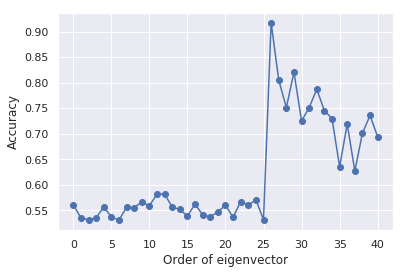

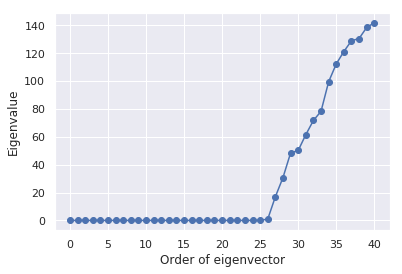

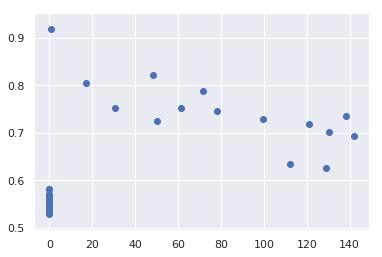

In [106]:
sns.set()
plt.plot(vec_idxs, accs, marker='o')
plt.xlabel("Order of eigenvector")
plt.ylabel("Accuracy")
plt.savefig('cora-01-classes-acc-over-egv.png')
plt.show()

plt.plot(vec_idxs, spectra, marker='o')
plt.xlabel("Order of eigenvector")
plt.ylabel("Eigenvalue")
plt.savefig('cora-01-classes-spectrum.png')
plt.show()

plt.scatter(spectra, accs, marker = 'o')
plt.show()

In [128]:
spectra[5]

(42.493645977970374+0j)

In [10]:
labels_pred = checkSign(vecs[:, 42])
accuracy = GetAccuracy(G_01, labels_pred)
print(accuracy)

0.5129932627526468


In [11]:
G_01_lc = nx.subgraph(G_01, max(nx.connected_components(G_01), key=len))
adj_matrix = nx.adjacency_matrix(G_01).toarray()
nx.number_of_nodes(G_01_lc)
# np.count_nonzero(~np.isfinite(laplacian))
# laplacian.shape

1039

In [21]:
clustering = SpectralClustering(n_clusters = 2,
                                assign_labels = "discretize",
                                affinity = 'precomputed',
                                n_components = 10, 
                                random_state = 0).fit(adj_matrix)

In [22]:
GetAccuracy(G_01, clustering.labels_)

0.5890279114533205

In [81]:
class_0 = [x for x,y in G_01.nodes(data=True) if y['label'] == 1]
class_1 = [x for x,y in G_01.nodes(data=True) if y['label'] == 2]
for v in class_0:
    for u in class_1:
        if G_01.has_edge(u,v):
            print(u,v)

1123756 124952
1123756 28230


In [103]:
nx.cut_size(G_01, class_1)

2

/user/abobu/home/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


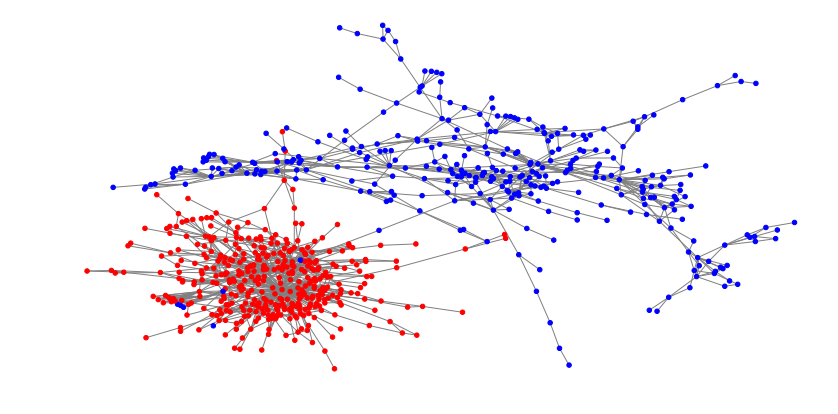

In [131]:
fig, ax1 = plt.subplots(1, 1, sharey = True, figsize=(14, 7))
pos = nx.spring_layout(G_01)
color_map = {1: 'blue', 2: 'red'}
ground_colors = [color_map[G_01.nodes[node]["label"]] for node in G_01.nodes]
nx.draw(G_01, pos, ax1, with_labels=False, node_color=ground_colors, edge_color = 'gray', node_size = 20)
plt.show()
plt.close()  

In [129]:
idx = 5
labels_pred = checkSign(vecs[:,idx])
pred_dict = dict(zip(list(G_01.nodes), labels_pred))
print(vals[idx])
    
for v in class_0:
    if pred_dict[v] == 0:
        nx.set_node_attributes(G_01, {v: '00'}, name = 'ground_vs_pred')
    else:
        nx.set_node_attributes(G_01, {v: '01'}, name = 'ground_vs_pred')

for v in class_1:
    if pred_dict[v] == 0:
        nx.set_node_attributes(G_01, {v: '10'}, name = 'ground_vs_pred')
    else:
        nx.set_node_attributes(G_01, {v: '11'}, name = 'ground_vs_pred')

(0.058290323700919584+0j)


In [130]:
class_0 = [x for x,y in G_01.nodes(data=True) if y['ground_vs_pred'] in ['00', '10']]
class_1 = [x for x,y in G_01.nodes(data=True) if y['ground_vs_pred'] in ['01', '11']]
nx.cut_size(G_01, class_0)

35